## In this notebook I want to see if training on a single sequence I am able to do a good PCA

In [1]:
## One analisys was done filtering N>=70 and M<=1000(gave 2ixTC00), the other N>=700, M<=10000(gave 3fbkA00)
## Third (the second could not sample from bmDCA somehow N>=100, M<=10000 gave (2cq4A01))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll_indep
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO
from torch.nn.functional import one_hot




In [2]:
from dynamic_loader import dynamic_collate_fn, dynamic_cluster

In [3]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used


/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [4]:
batch_structure_size = 1   ### I think with empty GPU we can go up to 16 easily
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)




In [5]:
train_dataset[0][0].shape

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


torch.Size([9894, 119])

In [8]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 24877
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 1000                                    ##Usual values are update steps=10^5, test_steps=10^2
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 48
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

Embedding(22, 21)

In [37]:
def get_loss_new(decoder, inputs, eta_J, eta_h):
    """eta_J is the multiplicative term in front of the penalized negative pseudo-log-likelihood for the Couplings
        if no penalty is proveded for the fields, we put the equal to one another """
    msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
    B, M, N = msas.shape
    #print(msas[0,1,1:5])
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)
    #eta = eta_J
    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    #penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    penalty = eta_J/B*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2)) + eta_h/B*torch.sum(fields**2) 
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 




def get_loss_loader(decoder, loader, eta_J, eta_h):
    decoder.eval()
    losses = []
    #with torch.no_grad():
    for effective_batch_size, inputs_packed in loader:
        npll_full = 0
        for inputs in inputs_packed:
            mini_batch_size = inputs[0].shape[0]
            #_, npll = get_loss_indep(decoder, inputs, eta_J, eta_h) ## For independent model without couplings
            _, npll = get_loss_new(decoder, inputs, eta_J, eta_h)
            npll_full += npll*mini_batch_size/effective_batch_size
        losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
#    with torch.cuda.amp.autocast():  ## autocasting mixed precision
    for inputs in inputs_packed[1]:
        mini_batch_size = inputs[0].shape[0]
        #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
        loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta_J, eta_h)
        loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
        train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
        #loss_penalty.backward()                         ## Get gradients
        #scaler.scale(loss_penalty).backward()
        loss_penalty.backward()
        loss_penalty_full += loss_penalty.detach()
        train_loss_full += train_batch_loss
    
    
    #scaler.step(optimizer)
    #scaler.update()
    optimizer.step()   

    return loss_penalty_full, train_loss_full

def train2(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
    with torch.cuda.amp.autocast():  ## autocasting mixed precision
        for inputs in inputs_packed[1]:
            mini_batch_size = inputs[0].shape[0]
            #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
            loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta_J, eta_h)
            loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
            train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
            loss_penalty.backward()                         ## Get gradients
            scaler.scale(loss_penalty).backward()
            loss_penalty.backward()
            loss_penalty_full += loss_penalty.detach()
            train_loss_full += train_batch_loss
    
    
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()   

    return loss_penalty_full, train_loss_full



In [38]:
## Let us also save the hyperparameters
#with summary_writer as w:
import warnings
warnings.filterwarnings("ignore")
lr = 1e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
eta_J = 1e-4
eta_h = 1e-4

start = time.time()
scaler = torch.cuda.amp.GradScaler()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    train_batch_losses_penalty = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs_packed in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler)
            loss_penalty.detach()
            #optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            train_batch_losses_penalty.append(loss_penalty.item())

        
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")


update_step: 1000, epoch: 1000.00  train: 0.00: 100%|██████████| 1000/1000 [01:28<00:00, 11.28it/s]

It took 88.628910779953 seconds


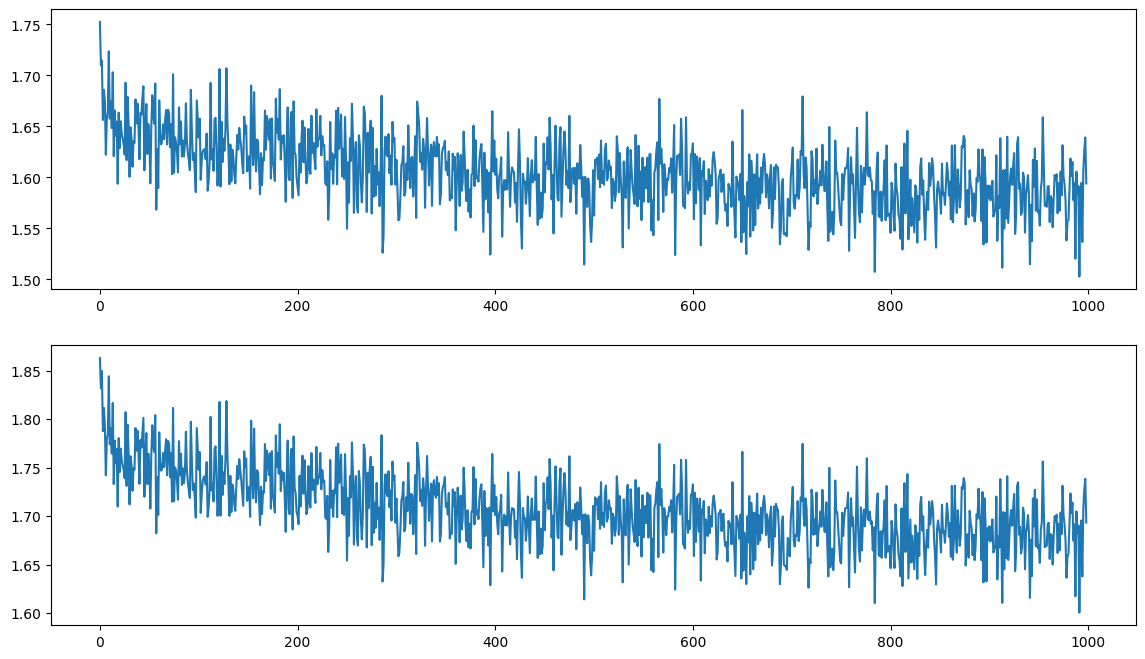

In [39]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax1.plot(train_batch_losses[1:10000])
ax2.plot(train_batch_losses_penalty[1:10000])

In [40]:
train_dataset.msas_paths

['/home/luchinoprince/split2/train/4x28C01_train.a3m.pt']

In [41]:
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.int)

In [42]:
train_msa.shape

torch.Size([9894, 119])

In [43]:
decoder.eval()

for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder(encodings, padding_mask)
        #if N == 97:
        #    break;
    #if N == 97:
    #    break


In [44]:
fields.max()

tensor(0.2269, device='cuda:0', grad_fn=<MaxBackward1>)

In [45]:
couplings.max()

tensor(1.7749, device='cuda:0', grad_fn=<MaxBackward1>)

In [46]:
N

119

In [47]:
### If all False + n=97 tell us that the protein we wanted is in the current batch, otherwise rerun above code until it happens.
print(N)
padding_mask[0, ::]


119


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [22]:
couplings.shape

torch.Size([1, 2499, 2499])

In [23]:
## Remember that when we have a batch we hav that we order 
## the MSA within the batch in decreasing order of lenght
#fields[1, :]

In [23]:
fields[0,:]

tensor([-0.8692,  0.9508, -0.3574,  ...,  0.2244,  0.0557, -0.5256],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [24]:
msas[0,:,:]

tensor([[20, 20, 20,  ...,  3,  0,  9],
        [20,  4,  0,  ...,  3, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20],
        ...,
        [20, 20, 20,  ..., 20, 20, 20],
        [20,  4,  2,  ...,  3,  0,  7],
        [20,  4,  2,  ...,  2,  9, 17]], device='cuda:0', dtype=torch.int32)

In [25]:
B

1

In [26]:
if B>1:
    couplings = couplings[0:1,:,:]
    fields=fields[0:1,:]

In [27]:
couplings.shape

torch.Size([1, 2499, 2499])

In [28]:
N

119

In [48]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

#B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "2cq4A01_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [49]:
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "2cq4A01_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -n 900 -d {out_dir} -o {out_file} -c bmdca2.config)

initializing sampler... 0.0462651 sec

sampling model with mcmc... 0.696405 sec
updating mcmc stats with samples... 0.0355016 sec
computing sequence energies and correlations... 0.0359929 sec
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 0.735 sec
updating mcmc stats with samples... 0.0320764 sec
computing sequence energies and correlations... 0.0376413 sec
writing final sequences... done


In [50]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [51]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [52]:
import torch.nn.functional as F
from torch.nn.functional import one_hot

In [53]:
################# NOT SURE THIS MAKES SENSE, I THINK WE CAN JUST THE THE NUMERICAL VALUES, NO NEED FOR TRANSLATION
##### THE bmDCA code works by generating according to potts, and the translating, hence we just have to 
##### avoid looking at the translated one.
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

In [54]:
msa_t[0:5, 0:18]

tensor([[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]])

In [55]:
msa_t.type()

'torch.LongTensor'

In [56]:
msa_t.shape

torch.Size([9000, 119])

In [57]:
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

In [58]:
M_potts, N = msa_t.shape
msa_t_emb = embeddings(msa_t).reshape(M_potts, N*q)
M_train, N = train_msa.shape
train_msa_emb = (embeddings(train_msa)).reshape(M_train, N*q)

In [59]:
msa_t_emb.shape

torch.Size([9000, 2499])

In [36]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
pca_mse = pca_mse.fit(train_msa_emb)

In [42]:
#a,b,c = np.linalg.svd(train_msa)

In [37]:
train_msa.shape

torch.Size([12066, 32])

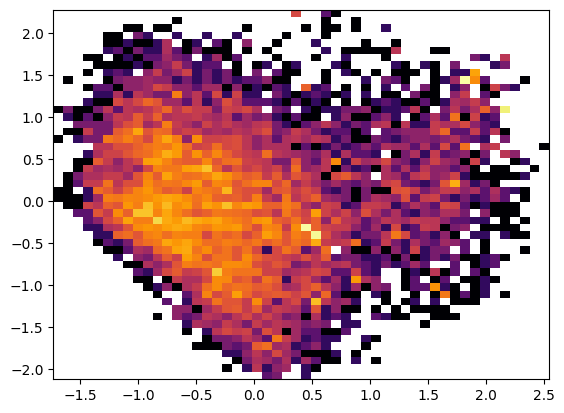

In [38]:
proj_true = pca_mse.transform(train_msa_emb)
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

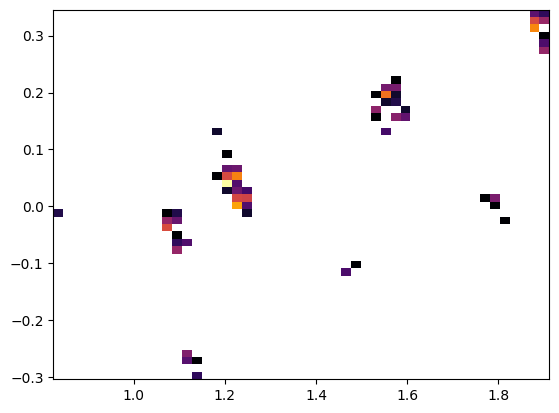

In [39]:
proj_potts = pca_mse.transform(msa_t_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_potts[:, 0], proj_potts[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()


In [40]:
msa_full=train_dataset[0][0]
msa_full.shape

torch.Size([12066, 32])

In [91]:
import h5py

In [92]:
with h5py.File('tensor_data_2cq4A01.h5', 'w') as file:
    # Create a dataset in the file
    dataset = file.create_dataset('tensor', data=msa_full)

### LOOK at _aux_julia.ipynb_

In [120]:
couplings2 = np.load("couplings_MSA.npy")
fields2 = np.load("fields_MSA.npy")

In [121]:
fields2

array([[-0.02339776,  0.0228768 ,  0.00869066, ...,  0.03118484,
         0.00118039, -0.0140192 ],
       [-0.02339776, -0.02756039, -0.03640457, ..., -0.04393613,
        -0.03206675, -0.0140192 ],
       [-0.02339776, -0.01231941,  0.00619111, ...,  0.02180152,
        -0.00713179, -0.0140192 ],
       ...,
       [-0.02339776, -0.03297511, -0.04353639, ..., -0.03048971,
        -0.03888294, -0.0140192 ],
       [-0.02339776, -0.03100165, -0.02864255, ..., -0.01630292,
        -0.02360864, -0.0140192 ],
       [ 0.1192325 ,  0.03538395,  0.00217436, ...,  0.02550837,
         0.07193026,  0.11076408]])

In [122]:
q,N=fields2.shape
M_potts, N = msa_t.shape


In [123]:
couplings2.shape

(21, 21, 97, 97)

In [124]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
#auxiliary_model_dir = "."

#B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "benchmark.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings2[aa1, aa2, i, j]
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields2[aa, i]
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [125]:
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_dir = auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'

out_file = 'samples_benchmark.txt'
samples_path = os.path.join(auxiliary_model_dir, "benchmark.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -n 1000 -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.0192437 sec

sampling model with mcmc... 0.451982 sec
updating mcmc stats with samples... 0.0162195 sec
computing sequence energies and correlations... 0.0272794 sec
writing final sequences... done


In [126]:
file='samples_benchmark_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t2 = torch.tensor(char_seq, dtype=torch.long)
cov_bk = compute_covariance(msa_t2, 21)

In [59]:
M_bk, N = msa_t2.shape
msa_t2_emb = embeddings(msa_t2).reshape(M_bk, N*q)
proj_potts2 = pca_mse.transform(msa_t2_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_potts2[:, 0], proj_potts2[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

NameError: name 'msa_t2' is not defined

#### THIS SEEMS VERY VERY ODD, LET US SEE THE SINGLE SITE FREQUENCIES OF THE THREE MSA

In [60]:
train_msa = train_msa.to(torch.int)

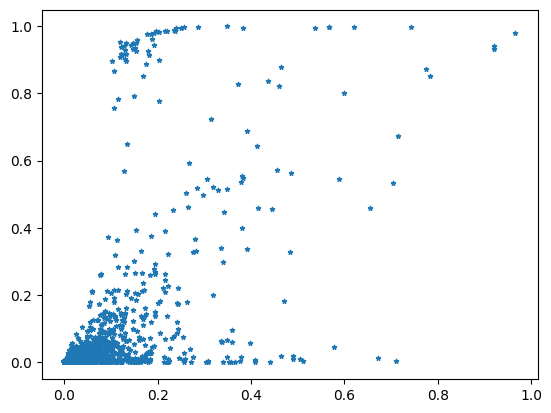

In [61]:
M,N = train_msa.shape 
M_potts = msa_t.shape[0]
fi_potts = torch.sum(embeddings(msa_t), dim=0)/M_potts
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts.flatten(), marker="*", s=10)

In [52]:
M,N = train_msa.shape 
M_potts2 = msa_t2.shape[0]
fi_potts2 = torch.sum(embeddings(msa_t2), dim=0)/M_potts2
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts2.flatten(), marker="*", s=10)

NameError: name 'msa_t2' is not defined

#### Second order

In [44]:
plt.scatter(cov_potts.flatten(), cov_bk.flatten(), marker="*", s=10)

NameError: name 'cov_bk' is not defined

In [63]:
cov_true = compute_covariance(train_msa.long(), q)

In [54]:
plt.scatter(cov_true.flatten(), cov_bk.flatten(), marker="*", s=10)

NameError: name 'cov_bk' is not defined

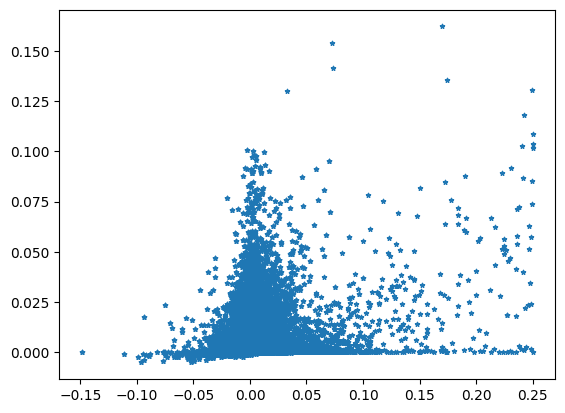

In [55]:
plt.scatter(cov_true.flatten(), cov_potts.flatten(), marker="*", s=10)

In [64]:
scipy.stats.pearsonr(cov_true.flatten(), cov_potts.flatten())

PearsonRResult(statistic=0.5458812956632763, pvalue=0.0)

In [62]:
scipy.stats.pearsonr(cov_true.flatten(), cov_bk.flatten())

PearsonRResult(statistic=0.6911845054747521, pvalue=0.0)

## Checking the family they use in ArDCA to see if there could be a problem in how I do the PCA

#### Solved but forgot to save, recreate

In [3]:
from ioutils import read_fasta

In [4]:
fasta = "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/ArDCAData/data/PF00076/PF00076_mgap6.fasta"
msa = read_fasta(fasta)

In [7]:
msa[0].shape

torch.Size([137605, 70])

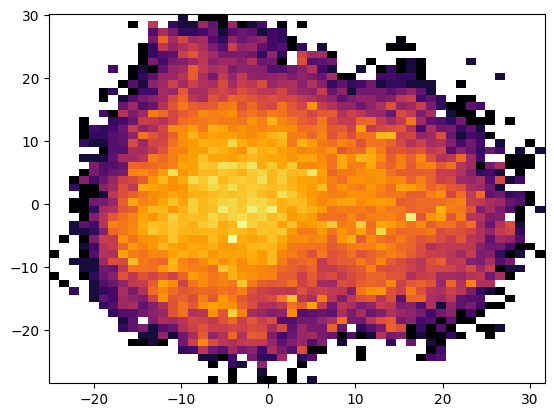

In [11]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
proj_true = pca_mse.fit_transform(msa[0])
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

## Let us test if the training with arDCA helps in some of the plots

In [136]:
samples_ardca=np.transpose(np.load("samples_ardca.npy"))
samples_ardca.shape

(10000, 97)

In [137]:
M_ardca, N = samples_ardca.shape
msa_ardca_emb = (embeddings(torch.tensor(samples_ardca))).reshape(M_ardca, N*q)

In [138]:
msa_ardca_emb.shape

torch.Size([10000, 2037])

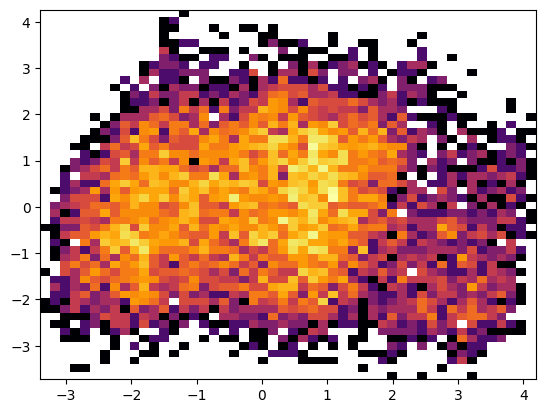

In [139]:
proj_ardca = pca_mse.transform(msa_ardca_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_ardca[:, 0], proj_ardca[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()


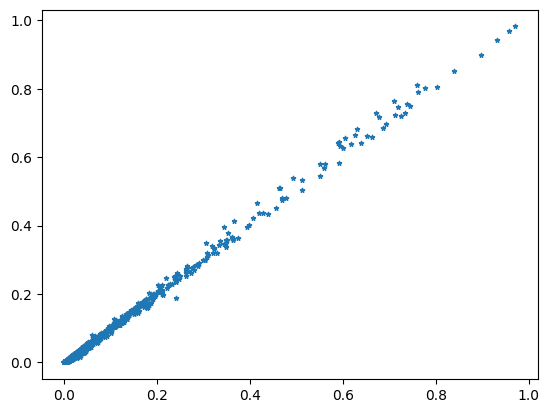

In [140]:
fi_ardca = torch.sum(msa_ardca_emb, dim=0)/M_ardca
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)

## Let us now see how it has learnt first and second moments on train/test sequences

In [57]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models/"
fname_par = 'model_25_06_2023_epoch_' + str(94.0) + '.pt'#+ '_ardca' + '.pt'
#fname_par = "model_20_01_2023_epoch_1000.0.pt"
checkpoint = torch.load(os.path.join(bk_dir, fname_par))


q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

In [58]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)  

In [59]:
batch_structure_size = 1   ### I think with empty GPU we can go up to 16 easily
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)



In [60]:
for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder.forward(encodings, padding_mask)

In [61]:
encodings.shape

torch.Size([1, 119, 512])

In [62]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

B,N,_ = encodings.shape
with open(os.path.join(auxiliary_model_dir, "2jm4A00_train_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [63]:
#auxiliary_model_dir = '/mnt/d/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "2jm4A00_train_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.0311692 sec

sampling model with mcmc... 0.795059 sec
updating mcmc stats with samples... 0.037995 sec
computing sequence energies and correlations... 0.0463522 sec
writing final sequences... done


In [64]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [65]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [66]:
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

In [67]:
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.long)
cov_train = compute_covariance(train_msa, q)

In [68]:
scipy.stats.pearsonr(cov_train.flatten(), cov_potts.flatten())

PearsonRResult(statistic=0.6324308650227752, pvalue=0.0)

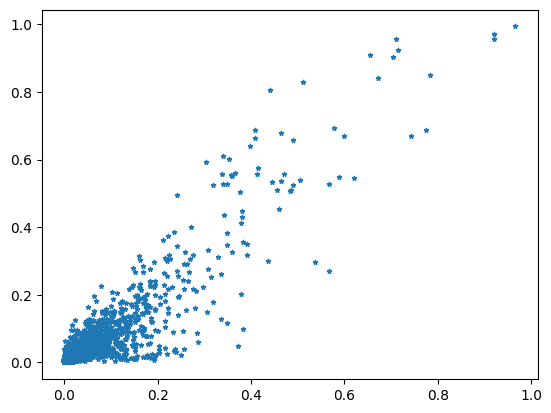

In [69]:
M,N = train_msa.shape 
M_ardca = msa_t.shape[0]
fi_ardca = torch.sum(embeddings(msa_t), dim=0)/M_ardca
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)

#### Ok now let us move to something in the superfamily

In [70]:
max_msas = 1
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/"

superfamily_test_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'test/superfamily'), encoding_dir, noise=0.0, max_msas=max_msas)
batch_structure_size_train = 1### I think with empty GPU we can go up to 16 easily
batch_structure_size=1
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=4, pin_memory=True, sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

In [71]:
superfamily_test_dataset.msas_paths

['/home/luchinoprince/split2/test/superfamily/3q7hA00.a3m.pt']

In [72]:
test_msa=torch.load(superfamily_test_dataset.msas_paths[0]).to(torch.long)
cov_test = compute_covariance(test_msa, q)
test_msa.shape

torch.Size([7994, 180])

In [73]:
for inputs_packed in superfamily_test_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder.forward(encodings, padding_mask)

In [74]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

B,N,_ = encodings.shape
with open(os.path.join(auxiliary_model_dir, "5k7fA01_superfamily_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [76]:
#auxiliary_model_dir = '/mnt/d/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "5k7fA01_superfamily_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file} -c bmdca2.config)

initializing sampler... 0.104143 sec

sampling model with mcmc... 2.79804 sec
updating mcmc stats with samples... 0.169927 sec
computing sequence energies and correlations... 0.0503187 sec
increasing wait time to 1500
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 4.93612 sec
updating mcmc stats with samples... 0.156485 sec
computing sequence energies and correlations... 0.050613 sec
increasing wait time to 2250
increasing burn-in time to 225000
maximum number of resamplings (1) reached. stopping...
writing final sequences... done


In [77]:
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts_test = compute_covariance(msa_t, 21)

In [78]:
scipy.stats.pearsonr(cov_test.flatten(), cov_potts_test.flatten())

PearsonRResult(statistic=0.3317858386318352, pvalue=0.0)

In [79]:
q=21
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

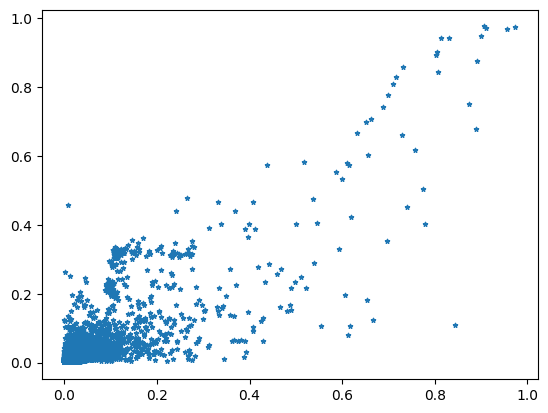

In [80]:
M,N = test_msa.shape 
M_ardca = msa_t.shape[0]
fi_ardca = torch.sum(embeddings(msa_t), dim=0)/M_ardca
msa_true_emb = embeddings(test_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)